# Alpaca Paper Trading — Mean Reversion Strategy

**Three operating modes:**
1. **Replay Mode** — Replay historical data day-by-day through the live pipeline. Validates that live system matches backtest results.
2. **Shadow Mode** — Run on live Alpaca data but don't submit orders. Track hypothetical P&L. Build confidence before going live.
3. **Live Mode** — Submit real paper-trade orders to Alpaca.

**Workflow:**
- Cell 1–3: Setup, connection, universe selection
- Cell 4–5: Data fetch + signal generation (shared by all modes)
- Cell 6: **Replay** — historical validation
- Cell 7–8: **Shadow / Live** — daily trading workflow
- Cell 9: Position monitoring & trade log export

In [1]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 1: IMPORTS & SETUP
# ══════════════════════════════════════════════════════════════════════════════

import sys, os, time, logging, importlib
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure src/ is on the path
src_dir = Path.cwd() if Path.cwd().name == 'src' else Path.cwd() / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# ─── Existing strategy modules ─────────────────────────────────────────────
from strategy_config import ConfigLoader
from strategies.mean_reversion import MeanReversionSignals, SignalConfig
from backtest.engine import BacktestEngine, BacktestConfig

# ─── New Alpaca modules ────────────────────────────────────────────────────
from connection.alpaca_connection import AlpacaConfig, AlpacaConnection, TradingMode
from data.alpaca_data import AlpacaDataAdapter
from execution.alpaca_executor import AlpacaExecutor, TradeDecision, TradeResult
from execution.simulation import SimulationEngine

# ─── Logging ───────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(name)s | %(levelname)s | %(message)s',
    datefmt='%H:%M:%S'
)

# ─── Load config ───────────────────────────────────────────────────────────
config = ConfigLoader()
signal_config = config.to_signal_config()
bt_config = config.to_backtest_config()
composite_weights = config.get_composite_weights()

print("✅ All modules loaded")
print(f"   Signal mode: {signal_config.signal_mode}")
print(f"   Kalman: {'ON' if signal_config.use_kalman else 'OFF'}")
print(f"   OU Gate: {'ON' if signal_config.use_predicted_return else 'OFF'}")
print(f"   Entry threshold: {bt_config.entry_threshold}")
print(f"   Exit threshold:  {bt_config.exit_threshold}")
print(f"   Stop loss: {bt_config.stop_loss_pct}")
print(f"   Max hold:  {bt_config.max_holding_days} days")

✅ All modules loaded
   Signal mode: gated
   Kalman: ON
   OU Gate: ON
   Entry threshold: 1.43
   Exit threshold:  0.5
   Stop loss: 0.1
   Max hold:  20 days


In [2]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 2: CONNECT TO ALPACA
# ══════════════════════════════════════════════════════════════════════════════
# Set trading mode here:
#   TradingMode.REPLAY  — historical replay (no API calls for orders)
#   TradingMode.SHADOW  — live data, simulated trades
#   TradingMode.LIVE    — submit real paper-trade orders

TRADING_MODE = TradingMode.REPLAY  # ← Change this as needed

# Load API keys from .env and create connection
alpaca_config = AlpacaConfig.from_env()
alpaca_config.trading_mode = TRADING_MODE

conn = AlpacaConnection(alpaca_config)
conn.test_connection()

print(f"\n🔧 Trading mode: {TRADING_MODE.value.upper()}")
if TRADING_MODE == TradingMode.REPLAY:
    print("   → Using historical data only. No Alpaca API orders.")
elif TRADING_MODE == TradingMode.SHADOW:
    print("   → Live data, simulated trades. No real orders submitted.")
else:
    print("   → ⚠️  LIVE MODE: Real paper-trade orders will be submitted!")

03:02:22 | connection.alpaca_connection | INFO | Trading client initialized (paper=True, mode=replay)


  ALPACA CONNECTION TEST
  Status:          AccountStatus.ACTIVE
  Mode:            PAPER
  Trading Mode:    REPLAY
  Cash:            $1,000,000.00
  Buying Power:    $2,000,000.00
  Portfolio Value: $1,000,000.00
  Market Open:     False
  Day Trades:      0
  PDT Flag:        False

🔧 Trading mode: REPLAY
   → Using historical data only. No Alpaca API orders.


In [3]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 3: SELECT TOP-30 UNIVERSE
# ══════════════════════════════════════════════════════════════════════════════
# Alpaca free tier: max 30 websocket symbols.
# We pick the 30 best mean-reverters from our 216-symbol universe.
# Criteria: lowest Hurst exponent → strongest mean reversion.

from data.universe_builder import SP500_CORE, NASDAQ_100_CORE, DOW_30, RUSSELL_2000_CORE

# Combine all curated symbols (unique)
all_symbols = sorted(set(SP500_CORE + NASDAQ_100_CORE + DOW_30 + RUSSELL_2000_CORE))
print(f"Total curated universe: {len(all_symbols)} symbols")

# ── Option A: Use cached Hurst data from backtest (fast) ──
# If you've already run the backtest notebook, load the parquet snapshots
hurst_cache = Path('../data/snapshots/hurst_rankings.csv')
if hurst_cache.exists():
    hurst_df = pd.read_csv(hurst_cache)
    top30 = hurst_df.nsmallest(30, 'hurst_exponent')['symbol'].tolist()
    print(f"Loaded cached Hurst rankings → top 30 selected")
else:
    # ── Option B: Compute Hurst from locally cached historical data ──
    daily_dir = Path('../data/historical/daily')
    if daily_dir.exists() and list(daily_dir.glob('*.parquet')):
        print("Computing Hurst exponents from local data...")
        signal_gen = MeanReversionSignals(signal_config)
        hurst_results = {}

        for pf in sorted(daily_dir.glob('*.parquet')):
            sym = pf.stem
            try:
                df = pd.read_parquet(pf)
                prices = df['close'] if 'close' in df.columns else df.iloc[:, 0]
                if len(prices) >= 100:
                    h = signal_gen.calculate_hurst_exponent(prices)
                    if h is not None and h < 0.5:
                        hurst_results[sym] = h
            except Exception:
                pass

        if hurst_results:
            ranked = sorted(hurst_results.items(), key=lambda x: x[1])
            top30 = [s for s, _ in ranked[:30]]
            print(f"Computed Hurst for {len(hurst_results)} mean-reverting symbols")
        else:
            # Fallback: diversified default selection
            top30 = DOW_30[:30]
            print("⚠️  No Hurst data available — falling back to DOW 30")
    else:
        top30 = DOW_30[:30]
        print("⚠️  No local data — falling back to DOW 30")

UNIVERSE = top30
print(f"\n📊 Trading Universe ({len(UNIVERSE)} symbols):")
for i in range(0, len(UNIVERSE), 10):
    print(f"   {', '.join(UNIVERSE[i:i+10])}")

Total curated universe: 269 symbols
Computing Hurst exponents from local data...
Computed Hurst for 208 mean-reverting symbols

📊 Trading Universe (30 symbols):
   BBWI, KTOS, LUMN, FIVE, DUOL, NEOG, MPC, AFRM, CORT, CELH
   CSX, NPO, BOOT, LPX, CVX, F, ATKR, FTDR, CRWD, DV
   COP, TILE, PCVX, CARG, NSIT, PLAB, ASGN, PM, GTES, DY


In [4]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 4: FETCH DATA — CACHE-FIRST + SMART INCREMENTAL UPDATE
# ══════════════════════════════════════════════════════════════════════════════
# Performance strategy:
#   1. Load cached parquet files from disk (< 1s for 30 symbols)
#   2. Check trading calendar — skip API on weekends/holidays
#   3. Fetch only NEW trading days since last cache date
#   4. Skip symbols with no IEX coverage (tracked automatically)
#   5. If no cache exists, full API fetch (first run only)
#
# Typical: <2s on weekends/holidays, 3-5s on next trading day.

LOOKBACK_DAYS = 1825  # ~10 years — Alpaca returns whatever is available

adapter = AlpacaDataAdapter(
    data_client=conn.data_client,
    data_feed=alpaca_config.data_feed,
    cache_dir=Path('../data/snapshots/alpaca_cache'),
)

print(f"Loading data for {len(UNIVERSE)} symbols (up to {LOOKBACK_DAYS} cal days)...")
print(f"Data feed: {alpaca_config.data_feed.upper()}")
print(f"Cache dir: {adapter.cache_dir}\n")

t0 = time.perf_counter()
price_df, volume_df, raw_bars = adapter.fetch_pipeline_data(
    symbols=UNIVERSE,
    lookback_days=LOOKBACK_DAYS,
    use_cache=True,
    verbose=True,
)
elapsed = time.perf_counter() - t0

trading_days = len(price_df)
trading_years = trading_days / 252

print(f"\n✅ Data ready in {elapsed:.1f}s")
print(f"   Date range : {price_df.index.min().date()} → {price_df.index.max().date()}")
print(f"   Trading days: {trading_days}  (~{trading_years:.1f} years)")
print(f"   Symbols OK  : {len(price_df.columns)}")
missing = set(UNIVERSE) - set(price_df.columns)
if missing:
    print(f"   Missing     : {', '.join(sorted(missing))}")
    if adapter._no_data_symbols:
        print(f"   ⚠️  No IEX data: {', '.join(sorted(adapter._no_data_symbols & set(UNIVERSE)))}")
        print(f"      (These need SIP feed or are delisted — excluded automatically)")
else:
    print(f"   Missing     : none")

# Update universe to only symbols with valid data
UNIVERSE = list(price_df.columns)

# Save/update cache for next run
adapter.save_cache(raw_bars, label='latest')
print(f"   💾 Cache saved → next run will be near-instant")

03:02:30 | connection.alpaca_connection | INFO | Data client initialized
03:02:30 | data.alpaca_data | INFO | Loaded 30 symbols from cache


Loading data for 30 symbols (up to 1825 cal days)...
Data feed: IEX
Cache dir: ../data/snapshots/alpaca_cache

   📦 Cache starts at 2024-10-01, but lookback requests 2021-02-18
   🔄 Cache too short — will do full re-fetch to get 1825 days of history
   🌐 Fetching 30 symbols from API (1825 days)...


03:02:31 | data.alpaca_data | INFO | Fetched data for 30/30 symbols
03:02:31 | data.alpaca_data | INFO | Pipeline data: 1254 days × 30 symbols (2021-02-18 to 2026-02-13)
03:02:31 | data.alpaca_data | INFO | Cached 30 symbols to ../data/snapshots/alpaca_cache


   ✅ Fetched 30 symbols in 0.9s

✅ Data ready in 1.0s
   Date range : 2021-02-18 → 2026-02-13
   Trading days: 1254  (~5.0 years)
   Symbols OK  : 30
   Missing     : none
   💾 Cache saved → next run will be near-instant


In [5]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 5: GENERATE SIGNALS
# ══════════════════════════════════════════════════════════════════════════════
# Same signal pipeline as the backtest notebook.
# Generates composite + individual signals for all symbols.

signal_gen = MeanReversionSignals(signal_config)

print(f"Generating signals for {len(UNIVERSE)} symbols...")
print(f"  Weights: {composite_weights}")
print(f"  Mode: {signal_config.signal_mode} | Gate: {signal_config.gate_signal}\n")

all_signals = {}
all_individual_signals = {}
t0 = time.perf_counter()

for i, symbol in enumerate(UNIVERSE):
    if symbol in price_df.columns and symbol in volume_df.columns:
        prices = price_df[symbol].dropna()
        volumes = volume_df[symbol].dropna()

        if len(prices) < 100:
            continue

        composite, individual = signal_gen.generate_composite_signal(
            prices, volumes, weights=composite_weights
        )
        all_signals[symbol] = composite
        all_individual_signals[symbol] = individual

    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(UNIVERSE)}...")

elapsed = time.perf_counter() - t0
print(f"\n✅ Signals generated for {len(all_signals)} symbols in {elapsed:.1f}s")

# Build DataFrames matching backtest format
signal_df = pd.DataFrame(all_signals)
zscore_df = pd.DataFrame({
    symbol: sigs['zscore']
    for symbol, sigs in all_individual_signals.items()
    if 'zscore' in sigs
})

# Align all data to common index
common_idx = price_df.index.intersection(signal_df.index)
price_df = price_df.loc[common_idx, signal_df.columns]
volume_df = volume_df.loc[common_idx, signal_df.columns]
signal_df = signal_df.loc[common_idx]
zscore_df = zscore_df.loc[common_idx]

# Show today's signals snapshot
latest_date = signal_df.index[-1]
latest_signals = signal_df.loc[latest_date].dropna().sort_values()
print(f"\n📡 Latest signals ({latest_date.date()}):")
print(f"   Strong longs  (signal < -{bt_config.entry_threshold}): "
      f"{(latest_signals < -bt_config.entry_threshold).sum()}")
print(f"   Strong shorts (signal > +{bt_config.entry_threshold}): "
      f"{(latest_signals > bt_config.entry_threshold).sum()}")
print(f"   Signal range: [{latest_signals.min():.2f}, {latest_signals.max():.2f}]")

Generating signals for 30 symbols...
  Weights: {'bollinger': 0.0, 'rsi_divergence': 0.75, 'rsi_level': 0.0}
  Mode: gated | Gate: rsi_divergence

  Processed 10/30...
  Processed 20/30...
  Processed 30/30...

✅ Signals generated for 30 symbols in 0.5s

📡 Latest signals (2026-02-13):
   Strong longs  (signal < -1.43): 0
   Strong shorts (signal > +1.43): 0
   Signal range: [0.00, 0.00]


## Mode A: Historical Replay

Replays historical data day-by-day through the live pipeline. Validates that the live execution system produces the same signals and trades as the backtest engine. Run this once before trusting the live system.

In [6]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 6: HISTORICAL REPLAY — MAXIMUM WINDOW
# ══════════════════════════════════════════════════════════════════════════════
# Replays the full signal_df day-by-day through the execution pipeline.
# Uses ALL available signal days (after warmup) for maximum coverage.
# Then compares against the backtest engine for consistency validation.

# Create executor in REPLAY mode
replay_config = AlpacaConfig.from_env()
replay_config.trading_mode = TradingMode.REPLAY
replay_conn = AlpacaConnection(replay_config)

replay_executor = AlpacaExecutor(
    connection=replay_conn,
    commission_pct=bt_config.commission_pct,
    max_position_pct=bt_config.max_position_size,
    max_total_exposure=bt_config.max_total_exposure,
)

sim = SimulationEngine(
    executor=replay_executor,
    initial_capital=bt_config.initial_capital,
    commission_pct=bt_config.commission_pct,
    slippage_pct=bt_config.slippage_pct,
)

# ── Use ALL available data (skip first 252 days for signal warmup) ──
WARMUP_DAYS = 252  # 1 year warmup for signal generation
if len(signal_df) > WARMUP_DAYS:
    replay_start = signal_df.index[WARMUP_DAYS]
else:
    replay_start = signal_df.index[0]
replay_end = signal_df.index[-1]

replay_trading_days = len(signal_df.loc[replay_start:replay_end])
replay_years = replay_trading_days / 252

print(f"🔄 Running replay over MAXIMUM available window:")
print(f"   Period     : {replay_start.date()} → {replay_end.date()}")
print(f"   Days       : {replay_trading_days}  (~{replay_years:.1f} years)")
print(f"   Warmup skip: first {WARMUP_DAYS} signal days")
print(f"   Capital    : ${bt_config.initial_capital:,.0f}")
print(f"   Commission : {bt_config.commission_pct:.2%} | Slippage: {bt_config.slippage_pct:.2%}")
print()

t0 = time.perf_counter()
replay_results = sim.run_replay(
    price_df=price_df,
    signal_df=signal_df,
    volume_df=volume_df,
    exit_signal_df=zscore_df,
    config=bt_config,
    start_date=replay_start,
    end_date=replay_end,
    verbose=True,
)
elapsed = time.perf_counter() - t0
print(f"\n⏱️  Replay completed in {elapsed:.1f}s")

🔄 Running replay over MAXIMUM available window:
   Period     : 2022-02-16 → 2026-02-13
   Days       : 1002  (~4.0 years)
   Warmup skip: first 252 signal days
   Capital    : $100,000
   Commission : 0.10% | Slippage: 0.05%


  HISTORICAL REPLAY
  Period: 2022-02-16 → 2026-02-13 (1002 days)
  Universe: 30 symbols
  Initial Capital: $100,000



  Day 250/1002 | 2023-02-14 | Equity: $159,408 (+59.4%) | Positions: 0 | Trades: 78
  Day 500/1002 | 2024-02-13 | Equity: $194,489 (+94.5%) | Positions: 0 | Trades: 148
  Day 750/1002 | 2025-02-12 | Equity: $226,630 (+126.6%) | Positions: 2 | Trades: 207
  Day 1000/1002 | 2026-02-11 | Equity: $262,461 (+162.5%) | Positions: 0 | Trades: 258

  SIMULATION RESULTS
  Final Equity:    $262,460.74
  Total Return:    +162.46%
  Sharpe Ratio:    0.69
  Max Drawdown:    -36.11%
  Total Trades:    258
  Win Rate:        98.1%
  Avg Trade P&L:   +6.41%
  Avg Winner:      +6.60%
  Avg Loser:       -2.92%
  Open Positions:  0

⏱️  Replay completed in 0.7s


Running backtest on same period for comparison...



════════════════════════════════════════════════════════════════════════
  METRIC                         REPLAY (Live Pipe)            BACKTEST
════════════════════════════════════════════════════════════════════════
  Period                         2022-02-16 → 2026-02-13  2022-02-16 → 2026-02-13
  Trading Days                                 1002                1002
  ─── Returns ───               
  Total Return                             +162.46%            +289.98%
  Annualized Return                         +27.47%             +40.81%
  Final Equity                          $262,460.74         $389,984.77
  ─── Risk ───                  
  Sharpe Ratio                                0.686               4.914
  Sortino Ratio                                 n/a              19.052
  Calmar Ratio                                  n/a              46.458
  Max Drawdown                              -36.11%               0.88%
  Max DD Duration                                 —       

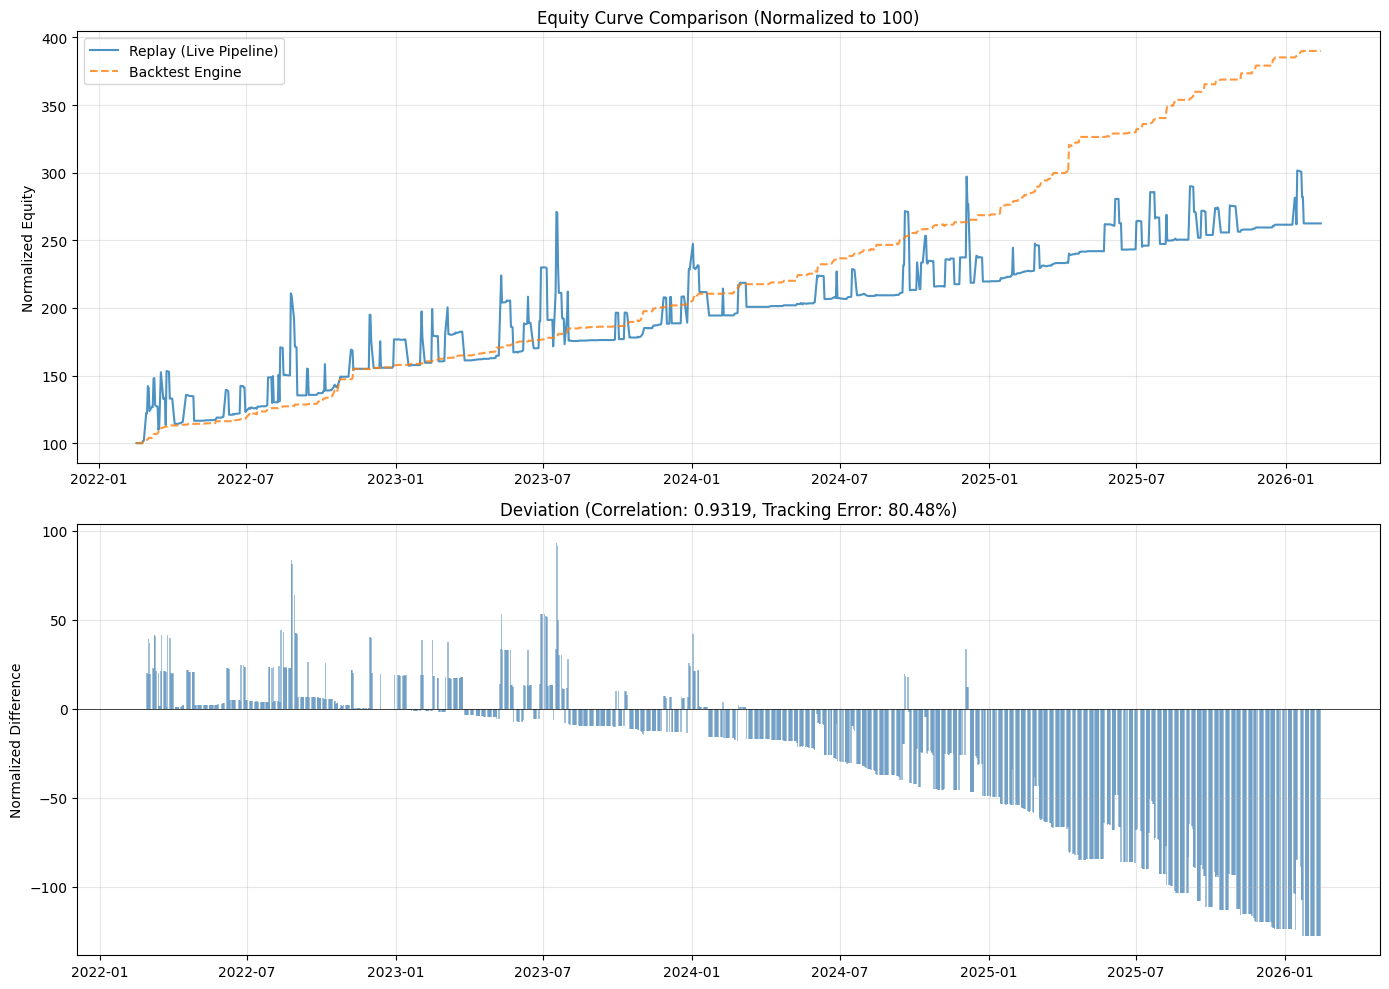


📊 Alignment Metrics:
   Correlation       : 0.9319
   Tracking Error    : 80.48% (annualized)
   Max Deviation     : 127.52
   Avg Deviation     : 36.61
   Overlapping Days  : 1002

⚠️  Moderate match. Check for timing/sizing differences.


In [7]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 7: DETAILED REPLAY vs BACKTEST COMPARISON
# ══════════════════════════════════════════════════════════════════════════════
# Runs the same period through BacktestEngine, then prints a comprehensive
# side-by-side numerical comparison with the replay simulation.

import matplotlib.pyplot as plt

print("Running backtest on same period for comparison...\n")

bt_engine = BacktestEngine(bt_config)
bt_results = bt_engine.run_backtest(
    price_df.loc[replay_start:],
    signal_df.loc[replay_start:],
    volume_df.loc[replay_start:],
    exit_signal_data=zscore_df.loc[replay_start:],
)

# ─── Replay metrics (from simulation dict) ─────────────────────────────────
r = replay_results   # shorthand

# ─── Backtest metrics (from BacktestResults object) ────────────────────────
bt = bt_results

# ─── SIDE-BY-SIDE TABLE ───────────────────────────────────────────────────
print(f"{'═'*72}")
print(f"  {'METRIC':<30s} {'REPLAY (Live Pipe)':>18s}  {'BACKTEST':>18s}")
print(f"{'═'*72}")

rows = [
    ("Period",
     f"{replay_start.date()} → {replay_end.date()}",
     f"{replay_start.date()} → {replay_end.date()}"),
    ("Trading Days",
     f"{len(r['equity_curve'])}",
     f"{len(bt.equity_curve)}"),
    ("─── Returns ───", "", ""),
    ("Total Return",
     f"{r['total_return_pct']:+.2f}%",
     f"{bt.total_return*100:+.2f}%"),
    ("Annualized Return",
     f"{(((1 + r['total_return_pct']/100) ** (252/max(len(r['equity_curve']),1))) - 1)*100:+.2f}%",
     f"{bt.annualized_return*100:+.2f}%"),
    ("Final Equity",
     f"${r['final_equity']:,.2f}",
     f"${bt.equity_curve.iloc[-1]:,.2f}"),
    ("─── Risk ───", "", ""),
    ("Sharpe Ratio",
     f"{r['sharpe_ratio']:.3f}",
     f"{bt.sharpe_ratio:.3f}"),
    ("Sortino Ratio",
     "n/a",
     f"{bt.sortino_ratio:.3f}"),
    ("Calmar Ratio",
     "n/a",
     f"{bt.calmar_ratio:.3f}"),
    ("Max Drawdown",
     f"{r['max_drawdown_pct']:.2f}%",
     f"{bt.max_drawdown*100:.2f}%"),
    ("Max DD Duration",
     "—",
     f"{bt.max_drawdown_duration} days"),
    ("─── Trades ───", "", ""),
    ("Total Trades",
     f"{r['total_trades']}",
     f"{bt.total_trades}"),
    ("Win Rate",
     f"{r['win_rate']:.1f}%",
     f"{bt.win_rate*100:.1f}%"),
    ("Avg Trade P&L",
     f"{r['avg_pnl_pct']:+.3f}%",
     f"—"),
    ("Avg Winner",
     f"{r['avg_win_pct']:+.3f}%",
     f"{bt.avg_win*100:+.3f}%"),
    ("Avg Loser",
     f"{r['avg_loss_pct']:+.3f}%",
     f"{bt.avg_loss*100:+.3f}%"),
    ("Profit Factor",
     "—",
     f"{bt.profit_factor:.2f}"),
    ("EV Per Trade",
     "—",
     f"{bt.ev_per_trade*100:.3f}%"),
    ("Avg Holding Days",
     "—",
     f"{bt.avg_holding_days:.1f}"),
    ("─── Exposure ───", "", ""),
    ("Avg Exposure",
     "—",
     f"{bt.avg_exposure*100:.1f}%"),
    ("Max Positions",
     "—",
     f"{bt.max_positions}"),
    ("Open Positions (end)",
     f"{r['open_positions']}",
     "—"),
    ("Total Commission",
     "—",
     f"${bt.total_commission:,.2f}"),
]

for label, val_r, val_bt in rows:
    if label.startswith("───"):
        print(f"  {label:<30s}")
    else:
        print(f"  {label:<30s} {val_r:>18s}  {val_bt:>18s}")

print(f"{'═'*72}")

# ─── REPLAY TRADE BREAKDOWN (if trades exist) ─────────────────────────────
if r.get('trades_df') is not None and len(r['trades_df']) > 0:
    tdf = r['trades_df']
    print(f"\n📋 Replay Trade Breakdown:")
    print(f"   Long trades : {(tdf['side']=='long').sum()}")
    print(f"   Short trades: {(tdf['side']=='short').sum()}")
    if 'holding_days' in tdf.columns:
        print(f"   Avg holding  : {tdf['holding_days'].mean():.1f} days")
        print(f"   Med holding  : {tdf['holding_days'].median():.0f} days")
    print(f"   Best trade   : {tdf['pnl_pct'].max()*100:+.2f}%  ({tdf.loc[tdf['pnl_pct'].idxmax(), 'symbol']})")
    print(f"   Worst trade  : {tdf['pnl_pct'].min()*100:+.2f}%  ({tdf.loc[tdf['pnl_pct'].idxmin(), 'symbol']})")
    print(f"   Total P&L $  : ${tdf['pnl'].sum():,.2f}")
    print(f"   Commission $ : ${tdf['commission'].sum():,.2f}")

    # Monthly returns
    eq = r['equity_curve']
    monthly = eq.resample('ME').last().pct_change().dropna() * 100
    if len(monthly) > 0:
        print(f"\n📅 Monthly Return Stats (Replay):")
        print(f"   Mean     : {monthly.mean():+.2f}%")
        print(f"   Median   : {monthly.median():+.2f}%")
        print(f"   Std Dev  : {monthly.std():.2f}%")
        print(f"   Best mo  : {monthly.max():+.2f}%")
        print(f"   Worst mo : {monthly.min():+.2f}%")
        print(f"   Positive : {(monthly > 0).sum()}/{len(monthly)} months")

# ─── EQUITY CURVE COMPARISON (chart) ──────────────────────────────────────
replay_equity = r['equity_curve']
bt_equity = bt.equity_curve

comparison = sim.compare_with_backtest(
    backtest_equity=bt_equity,
    label_sim='Replay (Live Pipeline)',
    label_bt='Backtest Engine',
)

print(f"\n📊 Alignment Metrics:")
print(f"   Correlation       : {comparison['correlation']:.4f}")
print(f"   Tracking Error    : {comparison['tracking_error_pct']:.2f}% (annualized)")
print(f"   Max Deviation     : {comparison['max_deviation']:.2f}")
print(f"   Avg Deviation     : {comparison['avg_deviation']:.2f}")
print(f"   Overlapping Days  : {comparison['common_days']}")

if comparison['correlation'] > 0.95:
    print("\n✅ Strong match! Live pipeline is consistent with backtest.")
elif comparison['correlation'] > 0.85:
    print("\n⚠️  Moderate match. Check for timing/sizing differences.")
else:
    print("\n❌ Significant divergence — investigate before going live.")

## Mode B: Shadow / Live Daily Trading

Run this section daily. In **Shadow mode**, it generates signals and tracks hypothetical trades without submitting orders. In **Live mode**, it submits real paper-trade orders to Alpaca.

**Daily workflow:** Run cells 1–5 (setup + data + signals), then cell 8 below.

In [8]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 8: DAILY SHADOW / LIVE EXECUTION
# ══════════════════════════════════════════════════════════════════════════════
# Processes today's signals through the execution pipeline.
# In SHADOW mode: logs hypothetical trades, tracks simulated P&L.
# In LIVE mode: submits real orders to Alpaca paper trading.
#
# State persistence: shadow positions survive across runs via trade log CSV.

# ─── Initialize or restore shadow state ────────────────────────────────────
SHADOW_LOG = Path('../data/snapshots/shadow_state.csv')

executor = AlpacaExecutor(
    connection=conn,
    commission_pct=0.0 if TRADING_MODE == TradingMode.LIVE else bt_config.commission_pct,
    max_position_pct=bt_config.max_position_size,
    max_total_exposure=bt_config.max_total_exposure,
)

shadow_sim = SimulationEngine(
    executor=executor,
    initial_capital=bt_config.initial_capital,
    commission_pct=bt_config.commission_pct if TRADING_MODE != TradingMode.LIVE else 0.0,
    slippage_pct=bt_config.slippage_pct if TRADING_MODE != TradingMode.LIVE else 0.0,
)

# Restore previous shadow positions if they exist
if SHADOW_LOG.exists() and TRADING_MODE == TradingMode.SHADOW:
    prev = pd.read_csv(SHADOW_LOG)
    if not prev.empty:
        for _, row in prev.iterrows():
            from execution.simulation import SimulatedPosition
            shadow_sim.positions[row['symbol']] = SimulatedPosition(
                symbol=row['symbol'],
                qty=int(row['qty']),
                side=row['side'],
                entry_price=float(row['entry_price']),
                entry_date=pd.Timestamp(row['entry_date']),
                signal_strength=float(row.get('signal_strength', 0)),
                current_price=float(row.get('current_price', row['entry_price'])),
            )
        shadow_sim.cash -= sum(
            p.entry_price * abs(p.qty) for p in shadow_sim.positions.values()
            if p.side == 'long'
        )
        print(f"♻️  Restored {len(shadow_sim.positions)} shadow positions")

# ─── Process today ─────────────────────────────────────────────────────────
today = signal_df.index[-1]  # Latest date with signals
print(f"\n{'═'*60}")
print(f"  DAILY EXECUTION — {today.date()} — {TRADING_MODE.value.upper()} MODE")
print(f"{'═'*60}")

if TRADING_MODE in (TradingMode.SHADOW, TradingMode.REPLAY):
    # Shadow: process through simulation engine
    shadow_sim.process_shadow_day(
        date=today,
        signal_df=signal_df,
        price_df=price_df,
        volume_df=volume_df,
        exit_signal_df=zscore_df,
        config=bt_config,
        verbose=True,
    )

    # Save shadow state for next run
    if shadow_sim.positions:
        state_rows = []
        for sym, pos in shadow_sim.positions.items():
            state_rows.append({
                'symbol': pos.symbol, 'qty': pos.qty, 'side': pos.side,
                'entry_price': pos.entry_price, 'entry_date': pos.entry_date,
                'signal_strength': pos.signal_strength,
                'current_price': pos.current_price,
            })
        pd.DataFrame(state_rows).to_csv(SHADOW_LOG, index=False)
        print(f"\n💾 Shadow state saved ({len(state_rows)} positions)")
    else:
        if SHADOW_LOG.exists():
            SHADOW_LOG.unlink()
        print("\n💾 No open positions — shadow state cleared")

else:
    # LIVE mode: generate decisions and submit orders
    current_positions = {}
    for pos in conn.get_positions():
        current_positions[pos['symbol']] = {
            'qty': int(pos['qty']),
            'side': 'long' if int(pos['qty']) > 0 else 'short',
            'entry_price': float(pos['avg_entry_price']),
            'entry_date': pd.Timestamp.now() - pd.Timedelta(days=1),  # Approximate
        }

    decisions = executor.generate_decisions_from_signals(
        signal_df=signal_df,
        price_df=price_df,
        volume_df=volume_df,
        exit_signal_df=zscore_df,
        date=today,
        current_positions=current_positions,
        config=bt_config,
    )

    if decisions:
        print(f"\n📋 {len(decisions)} trade decisions:")
        for d in decisions:
            print(f"   {d.action.upper():6s} {d.symbol:6s} x{d.target_qty:4d}  "
                  f"signal={d.signal_strength:+.3f}  {d.reason}")

        # Get current prices for execution
        current_prices = adapter.get_latest_prices([d.symbol for d in decisions])
        results = executor.execute_decisions(decisions, current_prices)

        print(f"\n📊 Execution results:")
        for r in results:
            status_icon = '✅' if r.status in ('filled', 'submitted') else '❌'
            print(f"   {status_icon} {r.decision.symbol} → {r.status} "
                  f"@ ${r.filled_price or 0:.2f}")
    else:
        print("\n😴 No trade signals today")

    # Show account summary
    account = conn.get_account()
    print(f"\n💰 Account: ${account['portfolio_value']:,.2f} "
          f"(cash: ${account['cash']:,.2f})")


════════════════════════════════════════════════════════════
  DAILY EXECUTION — 2026-02-13 — REPLAY MODE
════════════════════════════════════════════════════════════

── Shadow Day: 2026-02-13 ──
  Equity: $100,000.00 (daily: +0.000%)
  Positions: 0 (0L / 0S)
  Signals > threshold: 0

💾 No open positions — shadow state cleared


## Monitoring & Export

In [9]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 9: POSITION MONITORING DASHBOARD
# ══════════════════════════════════════════════════════════════════════════════
# Shows current positions, P&L, and signal status across all modes.

def show_dashboard(sim_engine=None, connection=None, mode=None):
    """Display position monitoring dashboard"""
    print(f"\n{'═'*70}")
    print(f"  POSITION DASHBOARD — {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    print(f"{'═'*70}")

    if mode in (TradingMode.SHADOW, TradingMode.REPLAY) and sim_engine:
        # Shadow/Replay positions
        print(f"\n  Mode: {mode.value.upper()} | Equity: ${sim_engine.equity:,.2f} "
              f"| Cash: ${sim_engine.cash:,.2f}")
        print(f"  Open positions: {len(sim_engine.positions)}")
        print(f"  Completed trades: {len(sim_engine.completed_trades)}")

        if sim_engine.positions:
            print(f"\n  {'Symbol':8s} {'Side':6s} {'Qty':>6s} {'Entry':>10s} "
                  f"{'Current':>10s} {'P&L':>10s} {'P&L%':>8s} {'Days':>5s}")
            print(f"  {'─'*65}")

            total_pnl = 0
            for sym, pos in sorted(sim_engine.positions.items()):
                days = (pd.Timestamp.now() - pos.entry_date).days
                pnl = pos.unrealized_pnl
                pnl_pct = pos.unrealized_pnl_pct * 100
                total_pnl += pnl
                icon = '🟢' if pnl >= 0 else '🔴'
                print(f"  {icon} {sym:6s} {pos.side:6s} {abs(pos.qty):6d} "
                      f"${pos.entry_price:9.2f} ${pos.current_price:9.2f} "
                      f"${pnl:9.2f} {pnl_pct:+7.2f}% {days:5d}")
            print(f"  {'─'*65}")
            print(f"  {'Total':55s} ${total_pnl:9.2f}")

        # Trade history summary
        if sim_engine.completed_trades:
            wins = sum(1 for t in sim_engine.completed_trades if t.pnl > 0)
            losses = len(sim_engine.completed_trades) - wins
            avg_pnl = np.mean([t.pnl_pct * 100 for t in sim_engine.completed_trades])
            print(f"\n  Trade History: {wins}W / {losses}L | "
                  f"Win rate: {wins/(wins+losses)*100:.1f}% | "
                  f"Avg P&L: {avg_pnl:+.2f}%")

    elif mode == TradingMode.LIVE and connection:
        # Live positions from Alpaca
        account = connection.get_account()
        positions = connection.get_positions()

        print(f"\n  Equity: ${account['portfolio_value']:,.2f} | "
              f"Cash: ${account['cash']:,.2f} | "
              f"Day trades: {account['daytrade_count']}/3")

        if positions:
            print(f"\n  {'Symbol':8s} {'Side':6s} {'Qty':>6s} {'Entry':>10s} "
                  f"{'Current':>10s} {'P&L':>10s} {'P&L%':>8s}")
            print(f"  {'─'*60}")

            for pos in positions:
                qty = int(pos['qty'])
                side = 'long' if qty > 0 else 'short'
                entry = float(pos['avg_entry_price'])
                current = float(pos['current_price'])
                pnl = float(pos['unrealized_pl'])
                pnl_pct = float(pos['unrealized_plpc']) * 100
                icon = '🟢' if pnl >= 0 else '🔴'
                print(f"  {icon} {pos['symbol']:6s} {side:6s} {abs(qty):6d} "
                      f"${entry:9.2f} ${current:9.2f} ${pnl:9.2f} {pnl_pct:+7.2f}%")
        else:
            print("\n  No open positions")

    # Show today's signals that hit thresholds
    if 'signal_df' in dir() or 'signal_df' in globals():
        latest = signal_df.iloc[-1].dropna()
        entries = latest[latest.abs() > bt_config.entry_threshold].sort_values()
        if len(entries) > 0:
            print(f"\n  📡 Active entry signals ({len(entries)}):")
            for sym, val in entries.items():
                direction = "SHORT" if val > 0 else "LONG "
                print(f"     {direction} {sym:6s}  signal={val:+.3f}")


# Run dashboard for the active mode
active_sim = shadow_sim if 'shadow_sim' in dir() else (sim if 'sim' in dir() else None)
show_dashboard(sim_engine=active_sim, connection=conn, mode=TRADING_MODE)


══════════════════════════════════════════════════════════════════════
  POSITION DASHBOARD — 2026-02-17 03:02
══════════════════════════════════════════════════════════════════════

  Mode: REPLAY | Equity: $100,000.00 | Cash: $100,000.00
  Open positions: 0
  Completed trades: 0


Equity curve exported: ../data/snapshots/trading_logs/equity_replay_20260217_0302.csv (1 days)
📈 Equity curve: ../data/snapshots/trading_logs/equity_replay_20260217_0302.csv


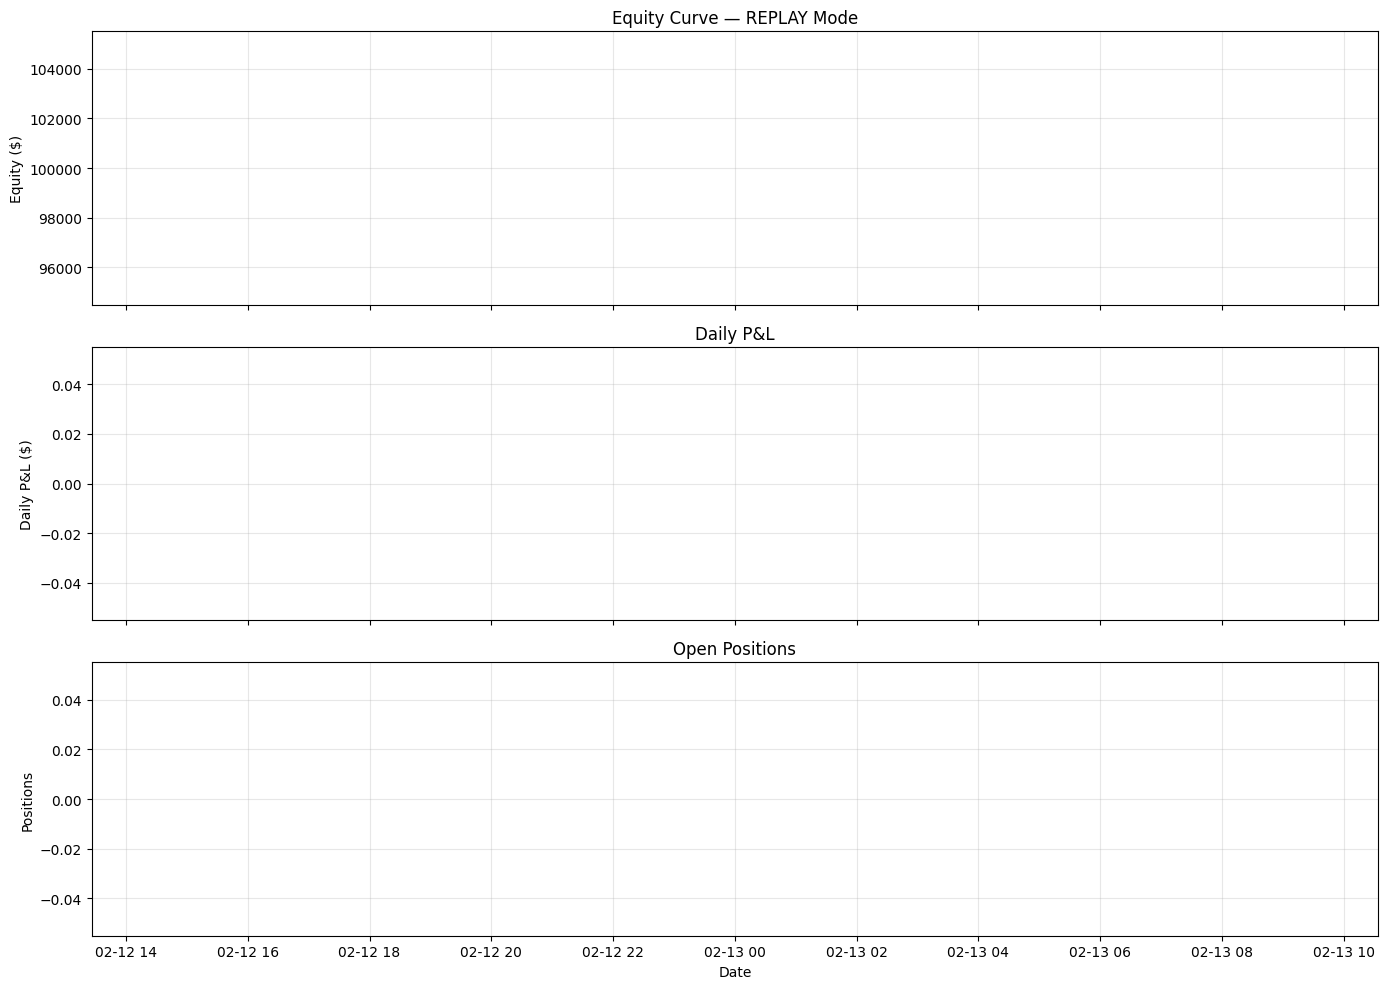

In [10]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 10: EXPORT TRADE LOGS & EQUITY CURVES
# ══════════════════════════════════════════════════════════════════════════════

export_dir = Path('../data/snapshots/trading_logs')
export_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Export from whichever sim engine is active
active = shadow_sim if 'shadow_sim' in dir() else (sim if 'sim' in dir() else None)

if active and active.completed_trades:
    trade_path = export_dir / f'trades_{TRADING_MODE.value}_{timestamp}.csv'
    active.export_trade_log(trade_path)
    print(f"📄 Trade log: {trade_path}")

if active and active.daily_snapshots:
    equity_path = export_dir / f'equity_{TRADING_MODE.value}_{timestamp}.csv'
    active.export_equity_curve(equity_path)
    print(f"📈 Equity curve: {equity_path}")

    # Plot equity curve
    snapshots_df = pd.DataFrame([
        {'date': s.date, 'equity': s.equity, 'daily_pnl': s.daily_pnl,
         'n_positions': s.n_positions, 'trades_entered': s.trades_entered,
         'trades_exited': s.trades_exited}
        for s in active.daily_snapshots
    ])
    snapshots_df.set_index('date', inplace=True)

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Equity
    axes[0].plot(snapshots_df['equity'], linewidth=2, color='blue')
    axes[0].set_ylabel('Equity ($)')
    axes[0].set_title(f'Equity Curve — {TRADING_MODE.value.upper()} Mode')
    axes[0].grid(alpha=0.3)

    # Daily P&L
    colors = ['green' if x >= 0 else 'red' for x in snapshots_df['daily_pnl']]
    axes[1].bar(snapshots_df.index, snapshots_df['daily_pnl'], color=colors, alpha=0.7)
    axes[1].set_ylabel('Daily P&L ($)')
    axes[1].set_title('Daily P&L')
    axes[1].grid(alpha=0.3)

    # Position count
    axes[2].fill_between(snapshots_df.index, 0, snapshots_df['n_positions'],
                         alpha=0.5, color='purple')
    axes[2].set_ylabel('Positions')
    axes[2].set_title('Open Positions')
    axes[2].set_xlabel('Date')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No trading data to export yet. Run replay or shadow mode first.")